### 定义函数

In [1]:
# load model

device = 'cuda'
resnet_layers = 18
with_pretrain = True

import models
import torch

def load_model(poseNetPath,dispNetPath):
    # create model
    print("=> creating model")
    disp_net = models.DispResNet(resnet_layers, with_pretrain).to(device)
    pose_net = models.PoseResNet(18, with_pretrain).to(device)

    # load weight
    print("=> load weight")
    weights = torch.load(poseNetPath)
    pose_net.load_state_dict(weights['state_dict'], strict=False)
    weights = torch.load(dispNetPath)
    disp_net.load_state_dict(weights['state_dict'], strict=False)

    # disp_net = torch.nn.DataParallel(disp_net)
    # pose_net = torch.nn.DataParallel(pose_net)
    
    return disp_net,pose_net

def load_dispNet(dispNetPath):
    disp_net = models.DispResNet(resnet_layers, with_pretrain).to(device)
    weights = torch.load(dispNetPath)
    disp_net.load_state_dict(weights['state_dict'], strict=False)
    # disp_net = torch.nn.DataParallel(disp_net)
    
    return disp_net

def load_denseNet(denseNetPath):
    disp_net = models.PTModel().to(device)
    weights = torch.load(denseNetPath)
    disp_net.load_state_dict(weights['state_dict'], strict=False)
    # disp_net = torch.nn.DataParallel(disp_net)
    
    return disp_net

/home/jiahan/miniconda3/envs/sfmLearner/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# load data

from datasets.sequence_folders import load_as_float
import custom_transforms
import numpy as np

normalize = custom_transforms.Normalize(mean=[0.45, 0.45, 0.45],
                                        std=[0.225, 0.225, 0.225])
train_transform = custom_transforms.Compose([
    # custom_transforms.RandomHorizontalFlip(),
    # custom_transforms.RandomScaleCrop(),
    custom_transforms.ArrayToTensor(),
    # normalize
])

def load_data(tgt_img_path,ref_imgs_paths, train_transform=train_transform):
    # tgt_img,_ = train_transform([load_as_float(tgt_img_path)],np.identity(3))
    # ref_imgs = [ train_transform(load_as_float(ref_img_path),np.identity(3))[0] for ref_img_path in ref_imgs_paths ]
    tgt_img,ref_imgs = load_as_float(tgt_img_path), [load_as_float(ref_img_path) for ref_img_path in ref_imgs_paths]
    imgs, intrinsics = train_transform([tgt_img] + ref_imgs, np.identity(3))
    tgt_img = imgs[0]
    ref_imgs = imgs[1:]

    tgt_img = tgt_img.unsqueeze(0).to(device)
    ref_imgs = [ref_img.unsqueeze(0).to(device) for ref_img in ref_imgs]
    
    return tgt_img,ref_imgs


In [3]:
# infer

from train import compute_depth,compute_pose_with_inv

def run_model(pose_net,disp_net,tgt_img,ref_imgs):
    pose_,pose_inv_ = compute_pose_with_inv(pose_net,tgt_img,ref_imgs)
    tgt_depth_,ref_depths_ = compute_depth(disp_net,tgt_img,ref_imgs)

    pose = [t.detach().cpu().numpy() for t in pose_]
    tgt_depth = tgt_depth_[0].detach().cpu().numpy()[0]
    ref_depths = [ref_depth[0].detach().cpu().numpy()[0] for ref_depth in ref_depths_]
    
    return pose,tgt_depth,ref_depths


In [4]:
def infer(poseNetPath,dispNetPath, tgt_img_path,ref_imgs_paths):
    disp_net,pose_net = load_model(poseNetPath,dispNetPath)
    tgt_img,ref_imgs = load_data(tgt_img_path,ref_imgs_paths)
    
    pose,tgt_depth,ref_depths = run_model(pose_net,disp_net,tgt_img,ref_imgs)
    
    return pose,tgt_depth,ref_depths

### 推理

In [1]:
# 输入图片的路径
poseNetPath = '/home/jiahan/jiahan/checkpoints/SC_Depth_on_C3VD/scene1_reprojection/11-09-20:32/exp_pose_model_best.pth.tar'
# dispNetPath = '/home/jiahan/jiahan/checkpoints/SC_Depth_on_C3VD/scene1_reprojection/11-09-20:32/dispnet_checkpoint.pth.tar'
dispNetPath = '/home/jiahan/jiahan/checkpoints/SC_Depth_on_C3VD/scene1/11-09-11:00'

# 模型参数的路径
tgt_img_path = "/home/jiahan/jiahan/datasets/C3VD/dataset_cecum_t1_a_4SCDepth/scenes/scene1/00010.jpg"
ref_imgs_paths = [
    "/home/jiahan/jiahan/datasets/C3VD/dataset_cecum_t1_a_4SCDepth/scenes/scene1/00095.jpg",
    "/home/jiahan/jiahan/datasets/C3VD/dataset_cecum_t1_a_4SCDepth/scenes/scene1/00105.jpg"
]

tgt_depth_gt = np.load("/home/jiahan/jiahan/datasets/C3VD/dataset_cecum_t1_a_4SCDepth/scenes/scene1/depth_gt/00010.npy")
ref_depths_gt = [
    np.load("/home/jiahan/jiahan/datasets/C3VD/dataset_cecum_t1_a_4SCDepth/scenes/scene1/depth_gt/00095.npy"),
    np.load("/home/jiahan/jiahan/datasets/C3VD/dataset_cecum_t1_a_4SCDepth/scenes/scene1/depth_gt/00105.npy")
]

NameError: name 'np' is not defined

In [18]:
# # 设置参数

# # tgt_idx = 2592
# tgt_idx = 2588

# # 无监督
# # poseNetPath, dispNetPath = '/root/autodl-tmp/SC_Depth_ckpts/resnet18_depth_256_scene1_V_debug/10-07-16:05/exp_pose_model_best.pth.tar','/root/autodl-tmp/SC_Depth_ckpts/resnet18_depth_256_scene1_V_debug/10-07-16:05/dispnet_model_best.pth.tar'

# # 监督poseNet
# # poseNetPath, dispNetPath = '/root/autodl-tmp/SC_Depth_ckpts/resnet18_depth_256_scene1_V_withoutposeNet/10-07-20:21/exp_pose_model_best.pth.tar','/root/autodl-tmp/SC_Depth_ckpts/resnet18_depth_256_scene1_V_withoutposeNet/10-07-20:21/dispnet_model_best.pth.tar'
# poseNetPath, dispNetPath = '/home/jiahan/jiahan/checkpoints/SC_Depth_on_C3VD/scene1/11-06-18:47/exp_pose_model_best.pth.tar','/home/jiahan/jiahan/checkpoints/SC_Depth_on_C3VD/scene1/11-06-18:47/dispnet_model_best.pth.tar'

# # tgt_img_path = '/root/autodl-tmp/dataset4SC_Depth/scene1_V/{:07d}.jpg'.format(tgt_idx)
# # ref_imgs_paths = ['/root/autodl-tmp/dataset4SC_Depth/scene1_V/{:07d}.jpg'.format(tgt_idx-1),'/root/autodl-tmp/dataset4SC_Depth/scene1_V/{:07d}.jpg'.format(tgt_idx+1)]
# idx = 200
# tgt_img_path = '/home/jiahan/jiahan/datasets/C3VD/dataset_cecum_t1_a_4SCDepth/scenes/scene1/{:05d}.jpg'.format(idx)
# ref_imgs_paths = ['/home/jiahan/jiahan/datasets/C3VD/dataset_cecum_t1_a_4SCDepth/scenes/scene1/{:05d}.jpg'.format(idx-1),'/home/jiahan/jiahan/datasets/C3VD/dataset_cecum_t1_a_4SCDepth/scenes/scene1/{:05d}.jpg'.format(idx+1)]


In [46]:
# 推理深度和位姿

disp_net,pose_net = load_model(poseNetPath,dispNetPath)
tgt_img,ref_imgs = load_data(tgt_img_path,ref_imgs_paths)

pose,tgt_depth,ref_depths = run_model(pose_net,disp_net,tgt_img,ref_imgs)

tgt_img = tgt_img.detach().cpu().numpy()[0].transpose((1,2,0))


=> creating model
=> load weight


pose[0] is  [[ 0.01573223 -0.01272262 -0.00367505 -0.02424559 -0.02981609 -0.00250274]]
tgt_depth.max, tgt_depth.min tgt_depth.mean is  1.0297542 0.14817438 0.39312208
tgt_depth_gt: .max, .min .mean is  98.29556725413902 0.0 43.159883339051206
scale is  109.7874829867275
113.054115 16.267693 43.159885
RMSE is  19.340180307681617 mm


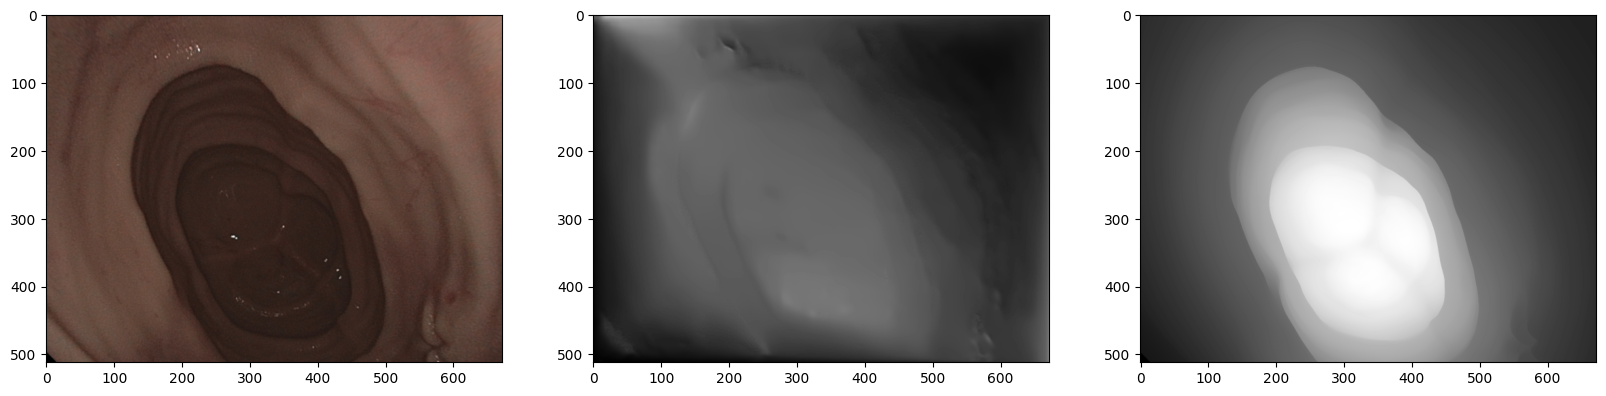

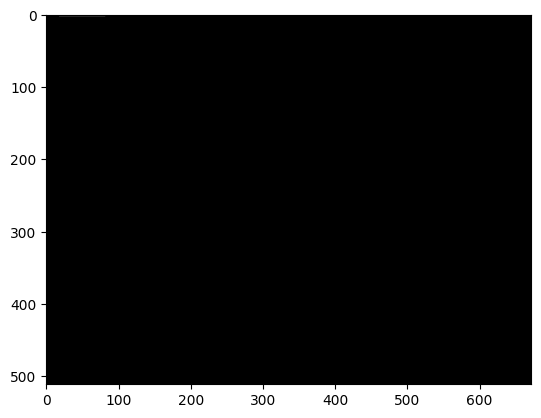

In [54]:

print("pose[0] is ",pose[0])

print("tgt_depth.max, tgt_depth.min tgt_depth.mean is ",tgt_depth.max(),tgt_depth.min(),tgt_depth.mean())
print("tgt_depth_gt: .max, .min .mean is ",tgt_depth_gt.max(),tgt_depth_gt.min(),tgt_depth_gt.mean())
import matplotlib.pyplot as plt

plt.figure(figsize=(20,20))
plt.subplot(1,3,1)
plt.imshow(tgt_img)
plt.subplot(1,3,2)
plt.imshow(tgt_depth[0],cmap='gray')
plt.subplot(1,3,3)
plt.imshow(tgt_depth_gt,cmap='gray')

# 与真实深度对比
h,w = tgt_depth_gt.shape
scale = tgt_depth_gt.mean() / tgt_depth[0].mean()
print("scale is ", scale)
tgt_depth_scaled = tgt_depth[0] * scale
print(tgt_depth_scaled.max(),tgt_depth_scaled.min(),tgt_depth_scaled.mean())
print("RMSE is ", np.sqrt( np.sum((tgt_depth_scaled - tgt_depth_gt)**2)/(h*w) ),"mm")

plt.figure()
plt.imshow(tgt_depth_scaled>0.8*tgt_depth_scaled.max(),cmap='gray')

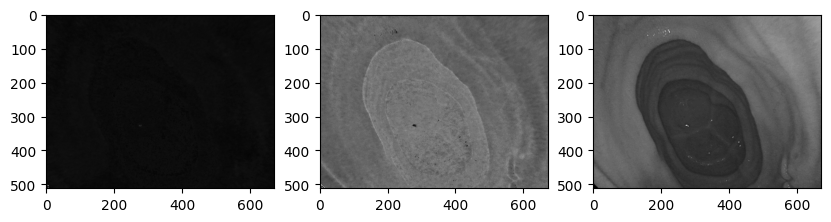

: 

In [56]:
import cv2
img= cv2.imread(tgt_img_path)
HSV = cv2.cvtColor(img,cv2.COLOR_BGR2HSV)
plt.figure(figsize=(10,10))
plt.subplot(1,3,1)
plt.imshow(HSV[...,0],cmap='gray')
plt.subplot(1,3,2)
plt.imshow(HSV[...,1],cmap='gray')
plt.subplot(1,3,3)
plt.imshow(HSV[...,2],cmap='gray')

(512, 672, 3)


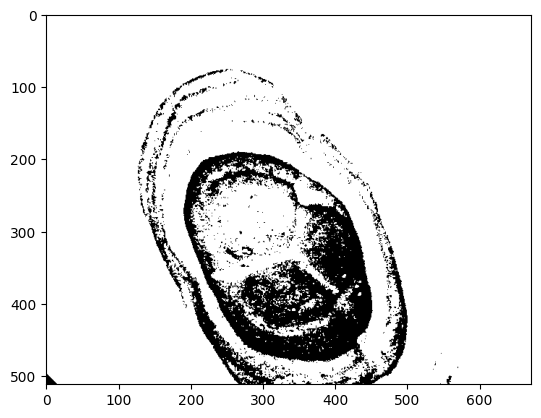

In [45]:
print(tgt_img.shape)
mask = tgt_img[...,0:1] >=0.2
plt.imshow(mask,cmap='gray')

In [8]:
# 输出真实的位姿
import numpy as np
from scipy.spatial.transform import Rotation

transforms = np.load("/root/autodl-tmp/dataset4SC_Depth/scene1_V/Transforms.npy")

T_tgt,T_refs = transforms[tgt_idx-2534],[ transforms[tgt_idx-2534-1],transforms[tgt_idx-2534+1] ]

pose_refs_gt = [ np.linalg.inv(T_refs[0])@T_tgt, np.linalg.inv(T_refs[1])@T_tgt ]

pose_gt = []
for ppose in pose_refs_gt:
    R,t = ppose[:3,:3],ppose[:3,3]
    rx,ry,rz = Rotation.from_matrix(R).as_euler('xyz')
    tx,ty,tz = t[0],t[1],t[2]
    pp = np.array([tx,ty,tz,rx,ry,rz])[None,...]
    pose_gt.append(pp)


In [9]:
# 变换深度图

np.set_printoptions(suppress=True)

print("=> 0")
print("pose_gt",pose_gt[0])
print("pose",pose[0])
t_gt,t = np.linalg.norm(pose_gt[0][0][:3]),np.linalg.norm(pose[0][0][:3])
print(t_gt,t)
print("t_gt/t",t_gt/t)

print("=> 1")
print("pose_gt",pose_gt[1])
print("pose",pose[1])
t_gt,t = np.linalg.norm(pose_gt[1][0][:3]),np.linalg.norm(pose[1][0][:3])
print(t_gt,t)
print("t_gt/t",t_gt/t)

=> 0
pose_gt [[ 0.74643839 -0.29230976  1.03851184  0.00022189  0.00438876  0.01053601]]
pose [[ 0.00244135  0.0035691   0.01200671 -0.00002068 -0.00034132  0.00028669]]
1.3119154392906034 0.0127616525
t_gt/t 102.80137642144433
=> 1
pose_gt [[ 0.66620103  0.73844769  0.02519845 -0.00857857  0.00209978 -0.01620079]]
pose [[-0.00225183  0.00317975 -0.00435363 -0.00021212 -0.00027515 -0.00080509]]
0.994868717148404 0.005842571
t_gt/t 170.279264411807


### 推理预训练的深度网络

In [5]:
import cv2

# path = "/root/autodl-tmp/SC_Depth_ckpts/pretrainDepth/10-10-19:11/dispnet_model_best.pth.tar"
# path = "/root/autodl-tmp/SC_Depth_ckpts/pretrainDepth/10-13-03:47/dispnet_model_best.pth.tar"
# path = "/root/autodl-tmp/SC_Depth_ckpts/pretrainDepth_DenseDepth/10-16-03:11/dispnet_model_best.pth.tar"
# path = "/home/jiahan/jiahan/checkpoints/SC_Depth_on_C3VD/scene1_lossMidas/12-18-15:42/dispnet_model_best.pth.tar"
# path = "/home/jiahan/jiahan/checkpoints/SC_Depth_on_C3VD/scene1_lossMidas/12-19-19:13/dispnet_model_best.pth.tar"
# path = "/home/jiahan/jiahan/checkpoints/SC_Depth_on_C3VD/scene1_lossMidas/12-20-18:46/dispnet_checkpoint.pth.tar"
# path = "/home/jiahan/jiahan/checkpoints/SC_Depth_on_C3VD/scene1_lossMidas/12-20-18:46/dispnet_model_best.pth.tar" # 尺度一致性
# path = "/home/jiahan/jiahan/checkpoints/SC_Depth_on_C3VD/scene1_lossMidas/12-22-14:53/dispnet_checkpoint.pth.tar"
# path = "/home/jiahan/jiahan/checkpoints/SC_Depth_on_C3VD/scene1_lossMidas/12-25-15:06/dispnet_checkpoint.pth.tar"
# path = "/home/jiahan/jiahan/checkpoints/SC_Depth_on_C3VD/scene1_lossMidas/hyper_1/12-25-20:13/dispnet_checkpoint.pth.tar"
# path = "/home/jiahan/jiahan/checkpoints/SC_Depth_on_C3VD/scene1_lossMidas/hyper_1/12-26-16:27/dispnet_checkpoint.pth.tar" # 尺度一致性
# path = "/home/jiahan/jiahan/checkpoints/SC_Depth_on_C3VD/scene1_lossMidas/12-26-19:29/dispnet_checkpoint.pth.tar"
# path = "/home/jiahan/jiahan/checkpoints/SC_Depth_on_C3VD/scene1_lossMidas/hyper_2/12-27-04:10/dispnet_checkpoint.pth.tar"
# path = "/home/jiahan/jiahan/checkpoints/SC_Depth_on_C3VD/scene1_lossMidas/hyper_3/12-28-03:41/dispnet_checkpoint.pth.tar"
# path = "/home/jiahan/jiahan/checkpoints/SC_Depth_on_C3VD/scene1_lossMidas/hyper_4/12-28-16:18/dispnet_checkpoint.pth.tar"

# path = "/home/jiahan/jiahan/checkpoints/SC_Depth_on_C3VD/scenes_all_lossMidas/12-29-20:30/dispnet_checkpoint.pth.tar"
# path = "/home/jiahan/jiahan/checkpoints/SC_Depth_on_C3VD/scenes_all_lossMidas/24-01-03-19:13/dispnet_checkpoint.pth.tar" # 皮尔逊不收敛
# path = "/home/jiahan/jiahan/checkpoints/SC_Depth_on_C3VD/scenes_all_lossMidas/24-01-03-00:03/dispnet_checkpoint.pth.tar" # cecum
# path = "/home/jiahan/jiahan/checkpoints/SC_Depth_on_C3VD/scenes_all_lossMidas/24-01-03-10:33/dispnet_checkpoint.pth.tar" # trans
# path = "/home/jiahan/jiahan/checkpoints/SC_Depth_on_C3VD/scenes_all_lossMidas/24-01-04-00:49/dispnet_checkpoint.pth.tar"
# path = "/home/jiahan/jiahan/checkpoints/SC_Depth_on_C3VD/scenes_all_lossMidas/24-01-04-16:30/dispnet_checkpoint.pth.tar" # 
# path = "/home/jiahan/jiahan/checkpoints/SC_Depth_on_C3VD/scenes_all_lossMidas/24-01-10-20:07/dispnet_checkpoint.pth.tar" # sigmoid 

# 皮尔逊消融实验
# path = "/home/jiahan/jiahan/checkpoints/SC_Depth_on_C3VD/scenes_all_lossMidas/24-01-16-23:06/dispnet_checkpoint.pth.tar" # sigmoid 
# path = "/home/jiahan/jiahan/checkpoints/SC_Depth_on_C3VD/scenes_all_lossMidas/24-01-17-19:06/dispnet_checkpoint.pth.tar" # trans
path = "/home/jiahan/jiahan/checkpoints/SC_Depth_on_C3VD/scenes_all_lossMidas/24-01-18-21:39/dispnet_checkpoint.pth.tar" # cecum

disp_net = load_dispNet(path)
# disp_net = load_denseNet(path)




### 推理位姿

In [44]:
# 推理位姿
prefix = "hyper_3/12-28-03:41"
# prefix = "12-20-18:46" # 尺度一致性
disp_path = "/home/jiahan/jiahan/checkpoints/SC_Depth_on_C3VD/scene1_lossMidas/{}/dispnet_checkpoint.pth.tar".format(prefix)
pose_path = "/home/jiahan/jiahan/checkpoints/SC_Depth_on_C3VD/scene1_lossMidas/{}/exp_pose_checkpoint.pth.tar".format(prefix)
tgt_img_path = "/home/jiahan/jiahan/datasets/C3VD/dataset_cecum_t1_a_4SCDepth/scenes/scene1/00010.jpg"
ref_imgs_paths = [
    "/home/jiahan/jiahan/datasets/C3VD/dataset_cecum_t1_a_4SCDepth/scenes/scene1/00007.jpg",
    "/home/jiahan/jiahan/datasets/C3VD/dataset_cecum_t1_a_4SCDepth/scenes/scene1/00090.jpg"
]

disp_net,pose_net = load_model(pose_path,disp_path)
tgt_img,ref_imgs = load_data(tgt_img_path,ref_imgs_paths)

pose,tgt_depth,ref_depths = run_model(pose_net,disp_net,tgt_img,ref_imgs)

tgt_img = tgt_img.detach().cpu().numpy()[0].transpose((1,2,0))


=> creating model
=> load weight


[[-0.00054396 -0.0010988   0.01517614 -0.00272539 -0.00045276 -0.00119217]]
[[ 0.00031452 -0.00161524  0.01035544 -0.00252844 -0.00046285 -0.00123065]]


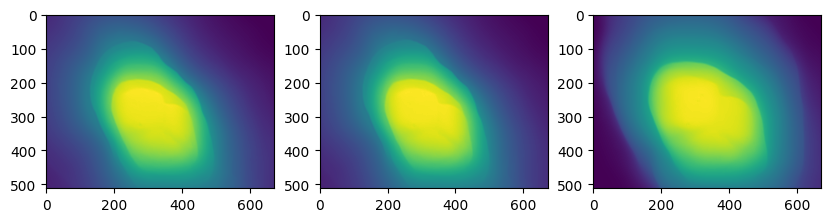

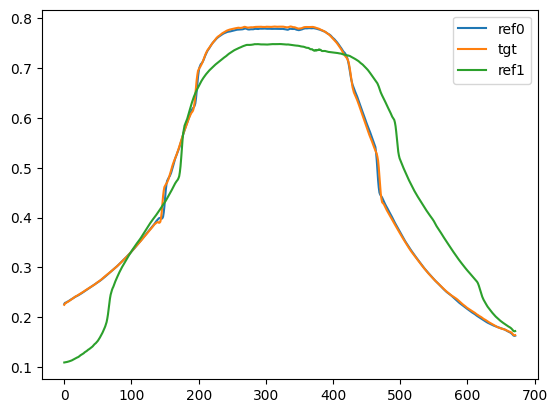

In [45]:

print(pose[0])
print(pose[1])
plt.figure(figsize=(10,10))
plt.subplot(1,3,1)
plt.imshow(ref_depths[0][0])
plt.subplot(1,3,2)
plt.imshow(tgt_depth[0])
plt.subplot(1,3,3)
plt.imshow(ref_depths[1][0])

plt.figure()
plt.plot(ref_depths[0][0][300],label='ref0')
plt.plot(tgt_depth[0][300],label='tgt')
plt.plot(ref_depths[1][0][300],label='ref1')
plt.legend()

In [46]:
# 推理全部位姿
from tqdm import trange
poses = []
for i in trange(0,200,3):
    tgt_img_path = "/home/jiahan/jiahan/datasets/C3VD/dataset_cecum_t1_a_4SCDepth/scenes/scene1/{:05d}.jpg".format(i)
    ref_imgs_paths = [
        "/home/jiahan/jiahan/datasets/C3VD/dataset_cecum_t1_a_4SCDepth/scenes/scene1/{:05d}.jpg".format(i+3)
    ]
    tgt_img,ref_imgs = load_data(tgt_img_path,ref_imgs_paths)
    pose,tgt_depth,ref_depths = run_model(pose_net,disp_net,tgt_img,ref_imgs)
    poses.append(pose[0])

100%|██████████| 67/67 [00:06<00:00, 10.23it/s]


[ 0.00056535 -0.00259525  0.01968888]
[ 0.00056535 -0.00259525  0.01968888]
[ 0.02563308 -0.03987196  0.4047804 ]
(67, 3)


/tmp/ipykernel_2267479/3166331374.py:13: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax1.scatter3D(positions[:,0],positions[:,1],positions[:,2], cmap='Blues')  #绘制散点图


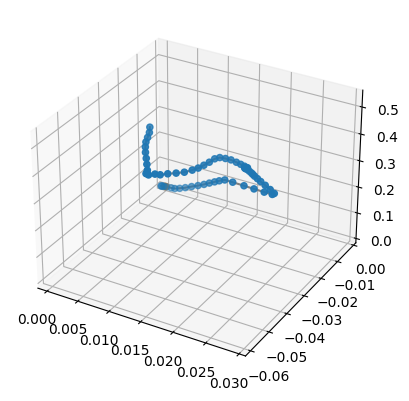

In [47]:
print(poses[0][0][:3])
positions = [poses[0][0][:3]]
for i in range(1,len(poses)):
    positions.append(positions[-1]+poses[i][0][:3])

print(positions[0])
print(positions[20])
positions = np.array(positions)
print(positions.shape)
#定义坐标轴
fig = plt.figure()
ax1 = plt.axes(projection='3d')
ax1.scatter3D(positions[:,0],positions[:,1],positions[:,2], cmap='Blues')  #绘制散点图
ax1.scatter3D(*positions[0])
ax1.plot3D(positions[:,0],positions[:,1],positions[:,2],'gray')    #绘制空间曲线
plt.show()


In [ ]:
train_transform = custom_transforms.Compose([
    # custom_transforms.RandomHorizontalFlip(),
    # custom_transforms.RandomScaleCrop(),
    custom_transforms.ArrayToTensor()
])

# load data
tgt_img_path = "/root/autodl-tmp/dataset4SC_Depth/scene1_bkp/0002538.jpg"
tgt_img_path = "/root/autodl-tmp/UCL/C_T1_L1_1_resized/FrameBuffer_0258.png"
tgt_img_path = "/home/jiahan/jiahan/datasets/C3VD/dataset_cecum_t1_a_4SCDepth/scenes/scene1/00124.jpg"
tgt_img= cv2.imread(tgt_img_path).astype(np.float32)
tgt_img,_ = train_transform([tgt_img],np.identity(3))

tgt_img = tgt_img[0].unsqueeze(0).to(device)
tgt_img_R = torch.concat((tgt_img[0][2:3],tgt_img[0][2:3],tgt_img[0][2:3])).unsqueeze(0).to(device)

with torch.no_grad():
    disp = disp_net(tgt_img)
    disp_R = disp_net(tgt_img_R)
print(disp)

# print(disp_net.alpha)

### 推理深度

=> trained RMSE is  14.535331953944377 mm
=> w/o trained RMSE is  5.422000619582375 mm
=> trained RMSE is  7.991001880221931 mm
=> w/o trained RMSE is  6.186249658601901 mm


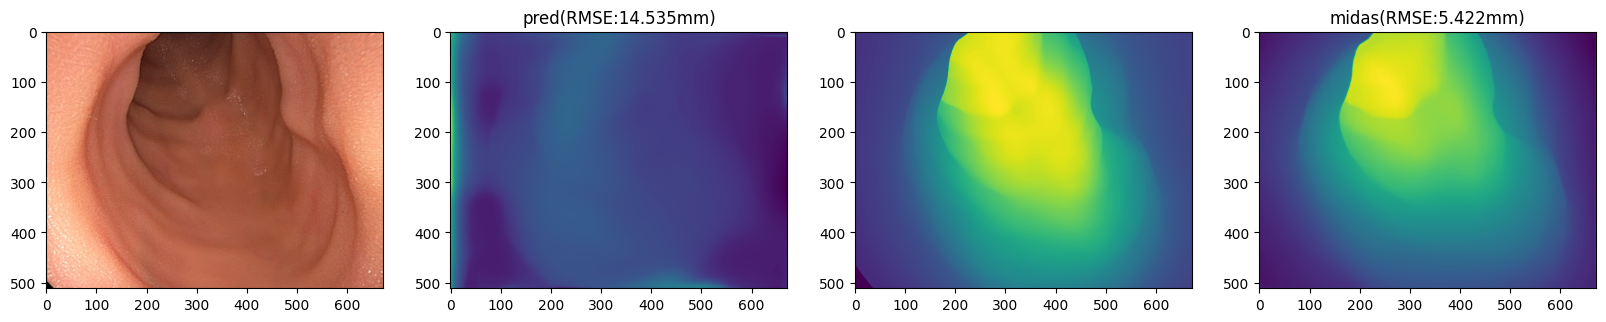

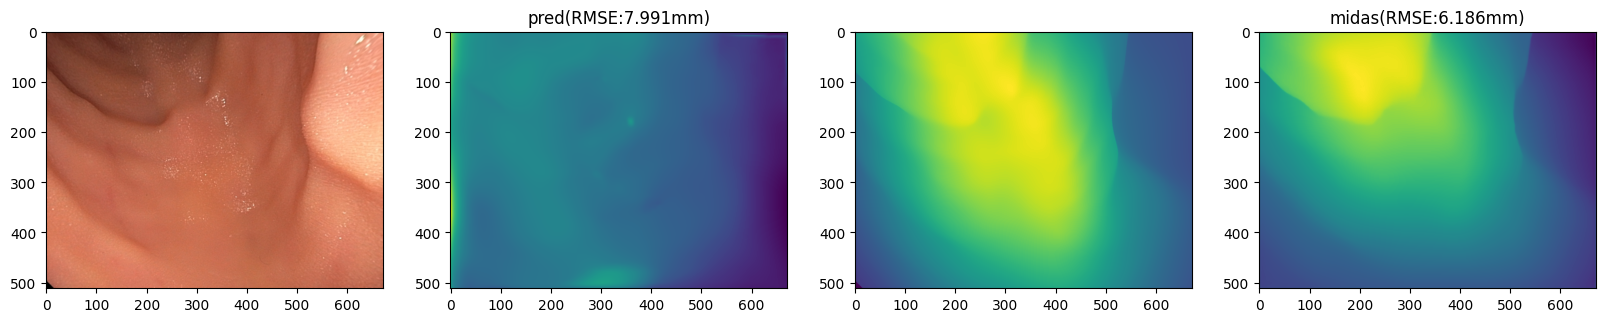

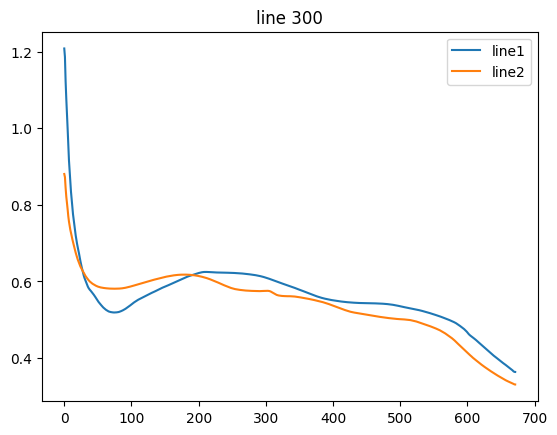

In [6]:

import matplotlib.pyplot as plt

import cv2

# disp_,disp_R_ = disp[0][0][0].detach().cpu().numpy(), disp_R[0][0][0].detach().cpu().numpy()
# disp_,disp_R_ = disp[0][0].detach().cpu().numpy(), disp_R[0][0].detach().cpu().numpy()
# # depth,depth_R = 1/disp_, 1/disp_R_
# depth,depth_R = disp_, disp_R_
# print(depth.max(),depth.min())
scene = "sigmoid_t3_b"
idx1,idx2 = "00004","00250"
tgt_img_path = f"/home/jiahan/jiahan/datasets/C3VD/dataset_{scene}_4SCDepth/scenes/scene1/{idx1}.jpg"
depth_gt = np.load(f"/home/jiahan/jiahan/datasets/C3VD/dataset_{scene}_4SCDepth/scenes/scene1/depth_gt/{idx1}.npy")
depth_midas = 1-cv2.imread(f"/home/jiahan/jiahan/datasets/C3VD/dataset_{scene}_4SCDepth/scenes/scene1/output_monodepth/{idx1}-dpt_beit_large_512.png",-1)/65535
h,w = depth_gt.shape
tgt_img= cv2.imread(tgt_img_path).astype(np.float32)
tgt_img,_ = train_transform([tgt_img],np.identity(3))

tgt_img = tgt_img[0].unsqueeze(0).to(device)
with torch.no_grad():
    disp = disp_net(tgt_img)
disp = disp[0][0][0].detach().cpu().numpy()
depth = 1/disp

# ratio = depth_gt.mean()/depth.mean()
ratio = np.median(depth_gt)/np.median(depth)
trained_RMSE = np.sqrt( np.sum((depth_gt - depth*ratio)**2)/(h*w) )
print("=> trained RMSE is ",  trained_RMSE,"mm")
line1 = depth[300]
# ratio = depth_gt.mean()/depth_midas.mean()
ratio = np.median(depth_gt)/np.median(depth_midas)
wotrained_RMSE = np.sqrt( np.sum((depth_gt - depth_midas*ratio)**2)/(h*w) )
print("=> w/o trained RMSE is ", wotrained_RMSE,"mm")
line1_gt = depth_gt[300]/100.0
plt.figure(figsize=(20,20))
plt.subplot(1,4,1)
plt.imshow(tgt_img.detach().cpu().numpy()[0].transpose((1,2,0))[...,::-1])
plt.subplot(1,4,2)
plt.title("pred(RMSE:{:.3f}mm)".format(trained_RMSE))
plt.imshow(depth)
plt.subplot(1,4,3)
plt.imshow(depth_gt)
plt.subplot(1,4,4)
plt.title("midas(RMSE:{:.3f}mm)".format(wotrained_RMSE))
plt.imshow(depth_midas)


tgt_img_path = f"/home/jiahan/jiahan/datasets/C3VD/dataset_{scene}_4SCDepth/scenes/scene1/{idx2}.jpg"
depth_gt = np.load(f"/home/jiahan/jiahan/datasets/C3VD/dataset_{scene}_4SCDepth/scenes/scene1/depth_gt/{idx2}.npy")
depth_midas = 1-cv2.imread(f"/home/jiahan/jiahan/datasets/C3VD/dataset_{scene}_4SCDepth/scenes/scene1/output_monodepth/{idx2}-dpt_beit_large_512.png",-1)/65535
h,w = depth_gt.shape
tgt_img= cv2.imread(tgt_img_path).astype(np.float32)
tgt_img,_ = train_transform([tgt_img],np.identity(3))

tgt_img = tgt_img[0].unsqueeze(0).to(device)
with torch.no_grad():
    disp = disp_net(tgt_img)
disp = disp[0][0][0].detach().cpu().numpy()
depth = 1/disp

# ratio = depth_gt.mean()/depth.mean()
ratio = np.median(depth_gt)/np.median(depth)
trained_RMSE = np.sqrt( np.sum((depth_gt - depth*ratio)**2)/(h*w) )
print("=> trained RMSE is ", trained_RMSE,"mm")
line2 = depth[300]
# ratio = depth_gt.mean()/depth_midas.mean()
ratio =np.median(depth_gt)/np.median(depth_midas)
wotrained_RMSE = np.sqrt( np.sum((depth_gt - depth_midas*ratio)**2)/(h*w) )
print("=> w/o trained RMSE is ", wotrained_RMSE,"mm")
line2_gt = depth_gt[300]/100.0
plt.figure(figsize=(20,20))
plt.subplot(1,4,1)
plt.imshow(tgt_img.detach().cpu().numpy()[0].transpose((1,2,0))[...,::-1])
plt.subplot(1,4,2)
plt.title("pred(RMSE:{:.3f}mm)".format(trained_RMSE))
plt.imshow(depth)
plt.subplot(1,4,3)
plt.imshow(depth_gt)
plt.subplot(1,4,4)
plt.title("midas(RMSE:{:.3f}mm)".format(wotrained_RMSE))
plt.imshow(depth_midas)

plt.figure()
plt.title("line {}".format(300))
plt.plot(line1, label='line1')
# plt.plot(line1_gt*100, label='line1_gt')
plt.plot(line2, label='line2')
# plt.plot(line2_gt, label='line2_gt')
plt.legend()

# plt.figure()
# plt.subplot(1,2,1)
# plt.imshow(tgt_img_R.detach().cpu().numpy()[0].transpose((1,2,0)))
# plt.subplot(1,2,2)
# plt.imshow(depth_R.astype(np.uint8))

# plt.figure()
# plt.imshow(plt.imread("/root/autodl-tmp/UCL/C_T1_L1_1_resized/Depth_0258.png"))

In [9]:
from path import Path
from tqdm import tqdm

rmses_midas, maes_midas = [], []
rmses_sc, maes_sc = [], []
ratios, ratios_midas = [], []

flag = False
ratio_const = 0.0
depth_gt = np.load("/home/jiahan/jiahan/datasets/C3VD/dataset_cecum_t1_a_4SCDepth/scenes/scene1/depth_gt/00214.npy")
h,w = depth_gt.shape
train_scenes, val_scenes = [], []
train_set, val_set = [[],[],[]], [[],[],[]]
root_path = Path("/home/jiahan/jiahan/datasets/C3VD/.dataset4SCDepth")
with open("/home/jiahan/jiahan/datasets/C3VD/.dataset4SCDepth/train.txt", 'r') as f:
    lines = f.readlines()
for line in lines:
    train_scenes.append(root_path/line[:-1])
for scene in train_scenes:
    tgt_img_path = sorted(scene.listdir("*.jpg"))
    depth_gt = sorted((scene/'depth_gt').listdir("*.npy"))
    depth_midas = sorted((scene/'output_monodepth').listdir("*.png"))
    train_set[0].extend(tgt_img_path)
    train_set[1].extend(depth_gt)
    train_set[2].extend(depth_midas)
with open("/home/jiahan/jiahan/datasets/C3VD/.dataset4SCDepth/val.txt", 'r') as f:
    lines = f.readlines()
for line in lines:
    val_scenes.append(root_path/line[:-1])
for scene in val_scenes:
    tgt_img_path = sorted(scene.listdir("*.jpg"))
    depth_gt = sorted((scene/'depth_gt').listdir("*.npy"))
    depth_midas = sorted((scene/'output_monodepth').listdir("*.png"))
    val_set[0].extend(tgt_img_path)
    val_set[1].extend(depth_gt)
    val_set[2].extend(depth_midas)

train_set = np.array(train_set).T
val_set = np.array(val_set).T
# for i in range(200):
#     tgt_img_path = "/home/jiahan/jiahan/datasets/C3VD/dataset_cecum_t1_a_4SCDepth/scenes/scene1/{:05d}.jpg".format(i)
#     depth_gt = np.load("/home/jiahan/jiahan/datasets/C3VD/dataset_cecum_t1_a_4SCDepth/scenes/scene1/depth_gt/{:05d}.npy".format(i))
#     depth_midas = 1-cv2.imread("/home/jiahan/jiahan/datasets/C3VD/dataset_cecum_t1_a_4SCDepth/scenes/scene1/output_monodepth/{:05d}-dpt_beit_large_512.png".format(i),-1)/65535
# for i in range(700):
#     tgt_img_path = "/home/jiahan/jiahan/datasets/C3VD/dataset_cecum_t1_b_4SCDepth/scenes/scene1/{:05d}.jpg".format(i)
#     depth_gt = np.load("/home/jiahan/jiahan/datasets/C3VD/dataset_cecum_t1_b_4SCDepth/scenes/scene1/depth_gt/{:05d}.npy".format(i))
#     depth_midas = 1-cv2.imread("/home/jiahan/jiahan/datasets/C3VD/dataset_cecum_t1_b_4SCDepth/scenes/scene1/output_monodepth/{:05d}-dpt_beit_large_512.png".format(i),-1)/65535
print("----- train set -------")
print(train_set[0])
print("----- val set --------")
print(val_set[0])
# for tgt_img_path,_depth_gt,_depth_midas in tqdm(train_set):
for tgt_img_path,_depth_gt,_depth_midas in tqdm(val_set):
    tgt_img= cv2.imread(tgt_img_path).astype(np.float32)
    tgt_img,_ = train_transform([tgt_img],np.identity(3))
    depth_gt = np.load(_depth_gt)
    depth_midas = 1-cv2.imread(_depth_midas,-1)/65535

    tgt_img = tgt_img[0].unsqueeze(0).to(device)
    with torch.no_grad():
        disp = disp_net(tgt_img)
    disp = disp[0][0][0].detach().cpu().numpy()
    depth = 1/disp

    # ratio = depth_gt.mean()/depth.mean()
    ratio = np.median(depth_gt)/np.median(depth)
    ratios.append(ratio)
    # NOTE 使用相同的放缩系数对估计深度图进行放缩
    if not flag:
        ratio_const = ratio
        # flag = True
    rmses_sc.append(np.sqrt( np.sum((depth_gt - depth*ratio_const)**2)/(h*w) ))
    maes_sc.append(np.mean(abs(depth_gt-depth*ratio_const)))

    # ratio = depth_gt.mean()/depth_midas.mean()
    ratio = np.median(depth_gt)/np.median(depth_midas)
    ratios_midas.append(ratio)
    maes_midas.append(np.mean(abs(depth_gt-depth_midas*ratio)))
    rmses_midas.append(np.sqrt( np.sum((depth_gt - depth_midas*ratio)**2)/(h*w)))

----- train set -------
['/home/jiahan/jiahan/datasets/C3VD/.dataset4SCDepth/scene_cecum_t1_b/00000.jpg'
 '/home/jiahan/jiahan/datasets/C3VD/.dataset4SCDepth/scene_cecum_t1_b/depth_gt/00000.npy'
 '/home/jiahan/jiahan/datasets/C3VD/.dataset4SCDepth/scene_cecum_t1_b/output_monodepth/00000-dpt_beit_large_512.png']
----- val set --------
['/home/jiahan/jiahan/datasets/C3VD/.dataset4SCDepth/scene_cecum_t1_a/00000.jpg'
 '/home/jiahan/jiahan/datasets/C3VD/.dataset4SCDepth/scene_cecum_t1_a/depth_gt/00000.npy'
 '/home/jiahan/jiahan/datasets/C3VD/.dataset4SCDepth/scene_cecum_t1_a/output_monodepth/00000-dpt_beit_large_512.png']


100%|██████████| 276/276 [00:08<00:00, 33.17it/s]


----- mean ------
=> mean rmse midas  8.252959404157115
=> mean rmse sc  18.229895686719637
=> mean mae midas  6.487165434855678
=> mean mae sc  13.944466698321474
------ ratio ------
=> sc std is  5.8174084701277655
=> sc min is  58.599046470130034
=> sc max is  79.41823588111163

=> midas std is  5.547877579313263
=> midas min is  70.23123105272545
=> midas max is  93.77977881715259


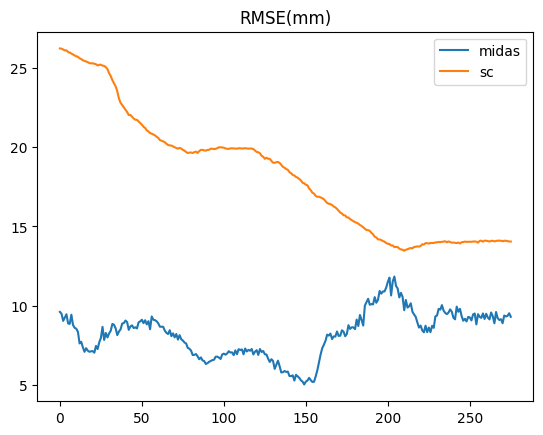

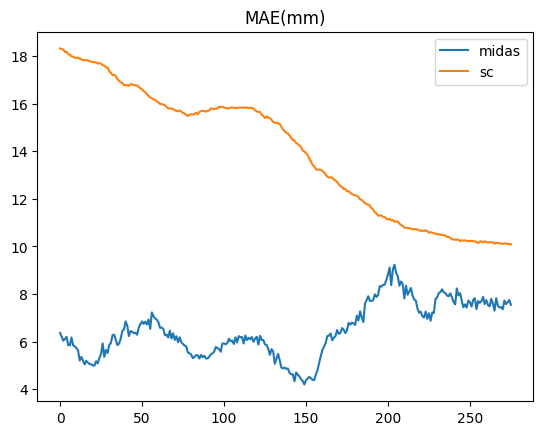

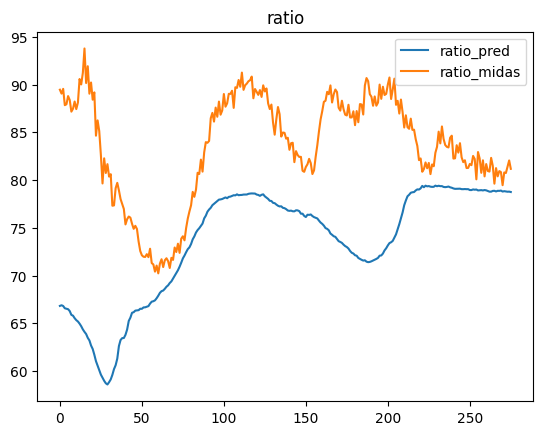

In [10]:
print("----- mean ------")
def meanon(data):
    avg = 0.0
    for d in data: avg += d
    avg = avg/len(data)
    return avg

print("=> mean rmse midas ", meanon(rmses_midas))
print("=> mean rmse sc ", meanon(rmses_sc))
print("=> mean mae midas ", meanon(maes_midas))
print("=> mean mae sc ", meanon(maes_sc))

plt.figure()
plt.title("RMSE(mm)")
plt.plot(rmses_midas, label='midas')
plt.plot(rmses_sc, label='sc')
plt.legend()

plt.figure()
plt.title("MAE(mm)")
plt.plot(maes_midas, label='midas')
plt.plot(maes_sc, label='sc')
plt.legend()

print("------ ratio ------")
print("=> sc std is ", np.std(ratios))
print("=> sc min is ", min(ratios))
print("=> sc max is ", max(ratios))
print("\n=> midas std is ", np.std(ratios_midas))
print("=> midas min is ", min(ratios_midas))
print("=> midas max is ", max(ratios_midas))
plt.figure()
plt.title("ratio")
plt.plot(ratios, label='ratio_pred')
plt.plot(ratios_midas, label='ratio_midas')
plt.legend()

=> trained RMSE is  10.153865076404758 mm
=> w/o trained RMSE is  5.870957826278764 mm


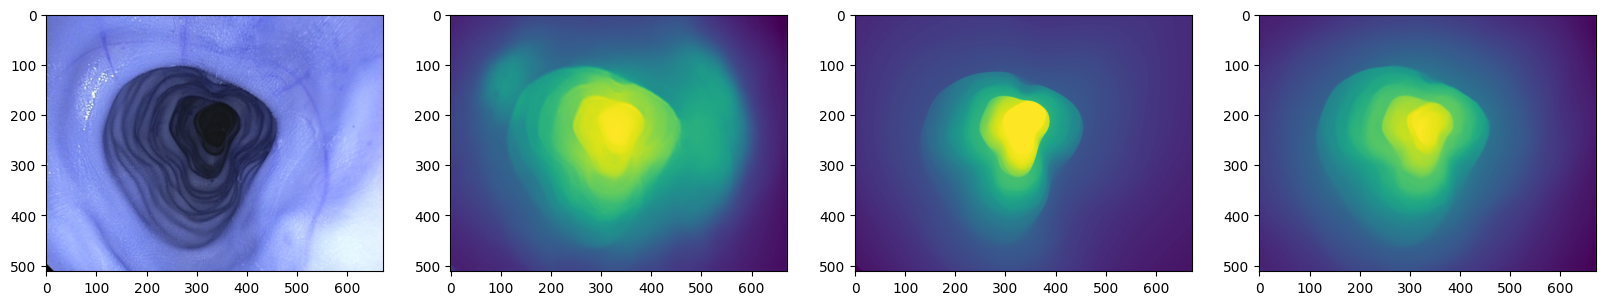

In [22]:

# unseen image

# tgt_img_path = "/home/jiahan/jiahan/datasets/C3VD/dataset_cecum_t2_a_4SCDepth/scenes/scene1/00038.jpg"
# depth_gt = np.load("/home/jiahan/jiahan/datasets/C3VD/dataset_cecum_t2_a_4SCDepth/scenes/scene1/depth_gt/00038.npy")
# depth_midas = 1-cv2.imread("/home/jiahan/jiahan/datasets/C3VD/MiDas_Depth_for_SC_Depth/cecum_t2_a_finetuning/00038-dpt_beit_large_512.png",-1)/65535

number = 100
tgt_img_path = "/home/jiahan/jiahan/datasets/C3VD/dataset_trans_t2_b_4SCDepth/scenes/scene1/{:05d}.jpg".format(number)
depth_gt = np.load("/home/jiahan/jiahan/datasets/C3VD/dataset_trans_t2_b_4SCDepth/scenes/scene1/depth_gt/{:05d}.npy".format(number))
depth_midas = 1-cv2.imread("/home/jiahan/jiahan/datasets/C3VD/MiDas_Depth_for_SC_Depth/trans_t2_b_finetuning/{:05d}-dpt_beit_large_512.png".format(number),-1)/65535
h,w = depth_gt.shape
tgt_img= cv2.imread(tgt_img_path).astype(np.float32)
tgt_img,_ = train_transform([tgt_img],np.identity(3))

tgt_img = tgt_img[0].unsqueeze(0).to(device)
with torch.no_grad():
    disp = disp_net(tgt_img)
disp = disp[0][0][0].detach().cpu().numpy()
depth = 1/disp

ratio = depth_gt.mean()/depth.mean()
print("=> trained RMSE is ", np.sqrt( np.sum((depth_gt - depth*ratio)**2)/(h*w) ),"mm")
line1 = depth[300]
ratio = depth_gt.mean()/depth_midas.mean()
print("=> w/o trained RMSE is ", np.sqrt( np.sum((depth_gt - depth_midas*ratio)**2)/(h*w) ),"mm")
line1_gt = depth_gt[300]/100.0
plt.figure(figsize=(20,20))
plt.subplot(1,4,1)
plt.imshow(tgt_img.detach().cpu().numpy()[0].transpose((1,2,0)))
plt.subplot(1,4,2)
plt.imshow(depth)
plt.subplot(1,4,3)
plt.imshow(depth_gt)
plt.subplot(1,4,4)
plt.imshow(depth_midas)


torch.Size([1, 3, 992, 1152])
torch.Size([1, 3, 496, 576])


/root/miniconda3/lib/python3.8/site-packages/torch/nn/functional.py:3679: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn(


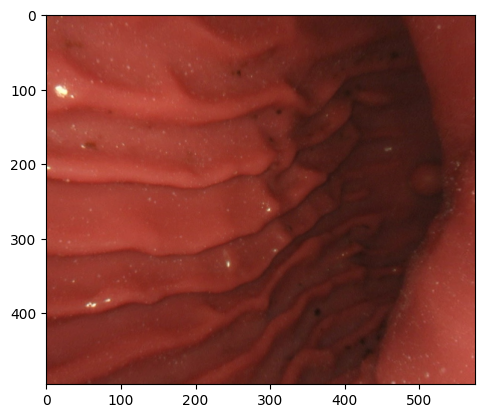

In [30]:
from torch.nn.functional import interpolate

print(tgt_img.shape)
newshape = [tgt_img.shape[0],tgt_img.shape[1],tgt_img.shape[2]/2,tgt_img.shape[3]/2]

tgt_img_ = interpolate(tgt_img,scale_factor=(0.5, 0.5))
# tgt_img_ = tgt_img.resize((1,3,496,576))
print(tgt_img_.shape)
plt.imshow(tgt_img_[0].detach().cpu().numpy().transpose((1,2,0))[...,::-1])

### 在我们的数据集上推理

In [8]:
tgt_img_path = "/home/jiahan/jiahan/datasets/scenes/scene1/0002600.jpg"

tgt_img= cv2.imread(tgt_img_path).astype(np.float32)
tgt_img,_ = train_transform([tgt_img],np.identity(3))

tgt_img = tgt_img[0].unsqueeze(0).to(device)
with torch.no_grad():
    disp = disp_net(tgt_img)
disp = disp[0][0][0].detach().cpu().numpy()
depth = 1/disp

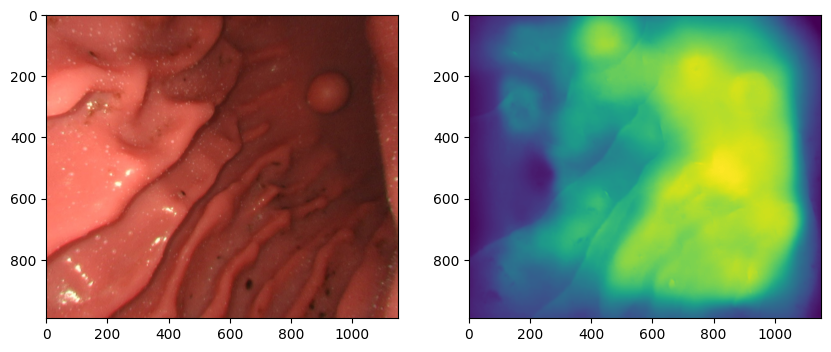

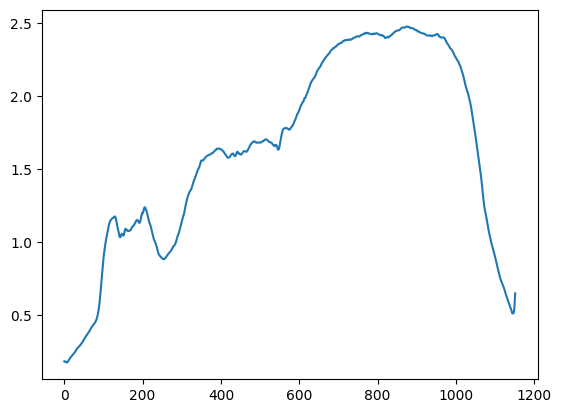

In [9]:
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(plt.imread(tgt_img_path))
plt.subplot(1,2,2)
plt.imshow(depth)
plt.figure()
plt.plot(depth[300])

### 尺度恢复

In [68]:
import cv2

# path = "/root/autodl-tmp/SC_Depth_ckpts/pretrainDepth/10-10-19:11/dispnet_model_best.pth.tar"
# path = "/root/autodl-tmp/SC_Depth_ckpts/pretrainDepth/10-13-03:47/dispnet_model_best.pth.tar"
# path = "/root/autodl-tmp/SC_Depth_ckpts/pretrainDepth_DenseDepth/10-16-03:11/dispnet_model_best.pth.tar"
# path = "/home/jiahan/jiahan/checkpoints/SC_Depth_on_C3VD/scene1_lossMidas/12-18-15:42/dispnet_model_best.pth.tar"
# path = "/home/jiahan/jiahan/checkpoints/SC_Depth_on_C3VD/scene1_lossMidas/12-19-19:13/dispnet_model_best.pth.tar"
# path = "/home/jiahan/jiahan/checkpoints/SC_Depth_on_C3VD/scene1_lossMidas/12-20-18:46/dispnet_checkpoint.pth.tar"
# path = "/home/jiahan/jiahan/checkpoints/SC_Depth_on_C3VD/scene1_lossMidas/12-21-11:48/dispnet_model_best.pth.tar"
path = "/home/jiahan/jiahan/checkpoints/SC_Depth_on_C3VD/scene1/11-09-11:00/dispnet_model_best.pth.tar"
disp_net = load_dispNet(path)
# disp_net = load_denseNet(path)

Transforms = np.load("/home/jiahan/jiahan/datasets/C3VD/dataset_cecum_t1_a_4SCDepth/scenes/scene1/Transforms.npy")


In [69]:
def predDepth(dispNet, img_path):
    img = cv2.imread(img_path).astype(np.float32)
    img,_ = train_transform([img], np.identity(3))
    
    img = img[0].unsqueeze(0).to(device)
    with torch.no_grad():
        disp = dispNet(img)
    disp = disp[0][0][0].detach().cpu().numpy()
    depth = 1/disp
    
    return depth

def RMSE_func(gt,pred):
    return np.sqrt( np.mean((gt-pred)**2) )

def MAE_func(gt,pred):
    return np.mean(abs(gt-pred))

In [70]:
transform1, transform2 = Transforms[4], Transforms[214]

img1_path, img2_path = "/home/jiahan/jiahan/datasets/C3VD/dataset_cecum_t1_a_4SCDepth/scenes/scene1/00004.jpg", "/home/jiahan/jiahan/datasets/C3VD/dataset_cecum_t1_a_4SCDepth/scenes/scene1/00214.jpg"
# img1,_ = train_transform([img1],np.identity(3))
# img2,_ = train_transform([img2],np.identity(3))

depth1_pred, depth2_pred = predDepth(disp_net, img1_path), predDepth(disp_net,img2_path)
depth1_gt, depth2_gt = np.load("/home/jiahan/jiahan/datasets/C3VD/dataset_cecum_t1_a_4SCDepth/scenes/scene1/depth_gt/00004.npy"), np.load("/home/jiahan/jiahan/datasets/C3VD/dataset_cecum_t1_a_4SCDepth/scenes/scene1/depth_gt/00214.npy")
depth1_midas, depth2_midas = 1-cv2.imread("/home/jiahan/jiahan/datasets/C3VD/dataset_cecum_t1_a_4SCDepth/scenes/scene1/output_monodepth/00004-dpt_beit_large_512.png",-1)/65535, 1-cv2.imread("/home/jiahan/jiahan/datasets/C3VD/dataset_cecum_t1_a_4SCDepth/scenes/scene1/output_monodepth/00214-dpt_beit_large_512.png",-1)/65535

=> translation from 1 to 2 is  38.806004 mm
=> p1 and p2 are  (428, 444) (514, 494)
...... plot point at p1 and p2

d1 and d2 are  0.5697705 0.3679784
=> ratio is  192.30684
=> RMSE
==> RMSE1 is  27.533080566814437 
==> RMSE2 is  23.804544310161923
=> MAE
==> MAE1 is  25.74819402231426 
==> MAE2 is  20.36997842861945



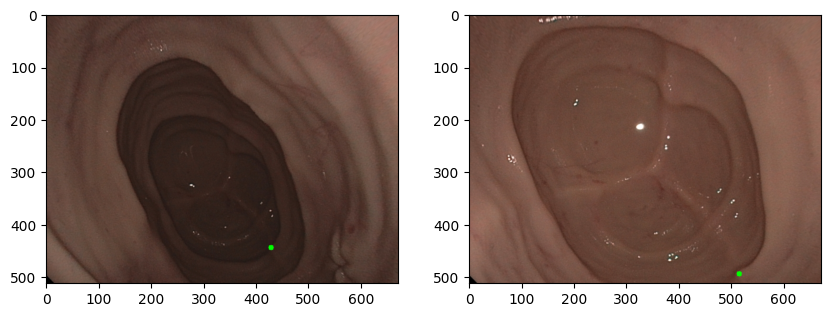

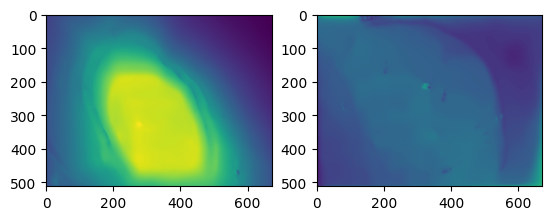

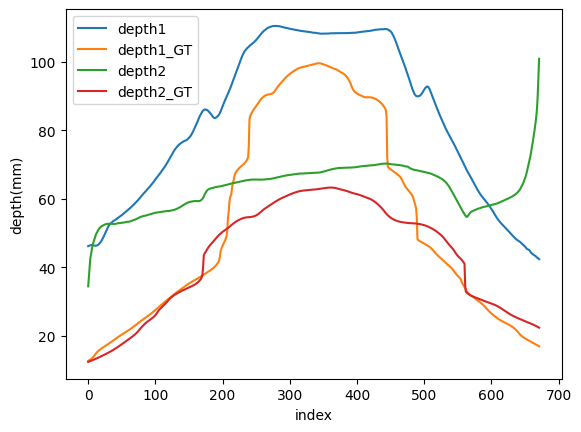

In [74]:
img1,img2 = plt.imread(img1_path), plt.imread(img2_path)

# 计算位移距离
translation_12 = np.linalg.norm( transform1[:3,3]-transform2[:3,3] )
print("=> translation from 1 to 2 is ", translation_12, "mm")

# 计算坐标
# p1,p2 = (334,334), (350,296)
# p1,p2 = (405,388), (460,395)
p1,p2 = (428,444), (514,494)
print("=> p1 and p2 are ",p1, p2)

# 画点
print("...... plot point at p1 and p2")
cv2.circle(img1,p1,5,(0,255,0),-1)
cv2.circle(img2,p2,5,(0,255,0),-1)

# 输出对应点的深度值
d1,d2 = depth1_pred[p1[1],p1[0]], depth2_pred[p2[1],p2[0]]
print("\nd1 and d2 are ", d1, d2)

ratio = translation_12 / (d1-d2)
print("=> ratio is ", ratio)

RMSE1, RMSE2 = RMSE_func(depth1_gt,depth1_pred*ratio), RMSE_func(depth2_gt, depth2_pred*ratio)
MAE1, MAE2 = MAE_func(depth1_gt,depth1_pred*ratio), MAE_func(depth2_gt,depth2_pred*ratio)
print("=> RMSE\n==> RMSE1 is ", RMSE1, "\n==> RMSE2 is ", RMSE2)
print("=> MAE\n==> MAE1 is ", MAE1, "\n==> MAE2 is ", MAE2)

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(img1)
plt.subplot(1,2,2)
plt.imshow(img2)

plt.figure()
plt.subplot(1,2,1)
plt.imshow(depth1_pred)
plt.subplot(1,2,2)
plt.imshow(depth2_pred)

lineNum = 400
plt.figure()
plt.ylabel("depth(mm)")
plt.xlabel("index")
plt.plot(depth1_pred[lineNum]*ratio, label='depth1')
plt.plot(depth1_gt[lineNum], label='depth1_GT')
plt.plot(depth2_pred[lineNum]*ratio, label='depth2')
plt.plot(depth2_gt[lineNum], label='depth2_GT')
plt.legend()

# plt.figure()
# plt.plot(depth1_midas[lineNum], label='depth1_midas')
# plt.plot(depth1_gt[lineNum]/100.0, label='depth1_GT')
# plt.plot(depth2_midas[lineNum], label='depth2_midas')
# plt.plot(depth2_gt[lineNum]/100.0, label='depth2_GT')
# plt.legend()
print("")